In [1]:
import numpy as np
from scipy.ndimage.filters import generic_filter as gf
from PIL import Image
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import scipy.stats.mstats as ms
import scipy.ndimage.morphology as morph
Image.MAX_IMAGE_PIXELS = None
import math

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
def create_circular_mask(radius):
    kernel = np.zeros((2*radius+1, 2*radius+1))
    y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    mask[radius][radius] = 0
    kernel[mask] = 1
    return kernel

In [3]:
def create_conic_mask(radius, direction):
    kernel = np.zeros((2*radius+1, 2*radius+1))
    y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
    
    if direction == 0: #topright
        mask = (x > y) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (x > 0)
    elif direction == 1: #righttop
        mask = (x > abs(y)) & (x**2 + y**2 <= radius**2) & (y < 0)
    elif direction == 2: #rightbottom
        mask = (x > abs(y)) & (x**2 + y**2 <= radius**2) & (y > 0)
    elif direction == 3: #bottomright
        mask = (abs(x) < y) & (x**2 + y**2 <= radius**2) & (x > 0)
    elif direction == 4: #bottomleft
        mask = (abs(x) < y) & (x**2 + y**2 <= radius**2) & (x < 0)
    elif direction == 5: #leftbottom
        mask = (abs(x) > abs(y)) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (y > 0)
    elif direction == 6: #lefttop
        mask = (abs(x) > abs(y)) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (y < 0)
    elif direction == 7: #topleft
        mask = (x > y) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (x < 0)
    kernel[mask] = 1
    return kernel

def conicMean(arr, maskRadius, threshold):
    masks = []
    for i in range(0, 8):
        masks.append(create_conic_mask(maskRadius, i))
    newArr = arr.copy()
    amountOfThresholds = 0
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            topRight = meanFromMask(arr, (i, j), masks[0])
            rightTop = meanFromMask(arr, (i, j), masks[1])
            rightBottom = meanFromMask(arr, (i, j), masks[2])
            bottomRight = meanFromMask(arr, (i, j), masks[3])
            bottomLeft = meanFromMask(arr, (i, j), masks[4])
            leftBottom = meanFromMask(arr, (i, j), masks[5])
            leftTop = meanFromMask(arr, (i, j), masks[6])
            topLeft = meanFromMask(arr, (i, j), masks[7])
            if topRight < threshold:
                if bottomLeft < threshold:
                    amountOfThresholds += 1
                    newArr[i][j] = 0.95 * (topRight if topRight < bottomLeft else bottomLeft)
            
            elif rightTop < threshold:
                if leftBottom < threshold:
                    amountOfThresholds += 1
                    newArr[i][j] = 0.95 * (leftBottom if leftBottom < rightTop else rightTop)
            
            elif rightBottom < threshold:
                if leftTop < threshold:
                    amountOfThresholds += 1
                    newArr[i][j] = 0.95 * (rightBottom if rightBottom < leftTop else leftTop)
            
            elif bottomRight < threshold:
                if topLeft < threshold:
                    amountOfThresholds += 1
                    newArr[i][j] = 0.95 * (bottomRight if bottomRight < topLeft else topLeft)
            if newArr[i][j] > arr[i][j]:
                newArr[i][j] = arr[i][j]
    print(amountOfThresholds)        
    return newArr

def meanFromMask(arr, index, mask):
    elementAmount = 0
    row = index[0]
    col = index[1]
    
    halfMask = len(mask) // 2
    
    arrLenRow = len(arr)
    arrLenCol = len(arr[row])
    
    elementSum = 0
    for i in range(-halfMask , halfMask):
        for j in range(-halfMask , halfMask):
            if arrLenCol > col + j + 1 or col + j + 1 >= 0 or arrLenRow > row + i + 1 or row + i + 1 >= 0:
                if mask[i + halfMask][j + halfMask] == 1:
                    if row + i + 1 < arrLenRow:
                        if col + j + 1 < arrLenCol:
                            elementSum += arr[row + i][col + j]
                            elementAmount += 1
    return elementSum / elementAmount if elementAmount != 0 else 0.99

In [95]:
def createOpposingMask(radius, distance, direction):    
    x = np.arange(0, (distance + radius)*2)
    y = np.arange(0, (distance + radius)*2)
    
    pointFromCenter = math.sqrt((distance + radius)**2/2)
    
    if direction == 0: #topleft
        mask = (x[np.newaxis,:]-pointFromCenter + radius)**2 + (y[:,np.newaxis]-pointFromCenter + radius)**2 < radius**2
    elif direction == 1: #topright
        mask = (x[np.newaxis,:]- pointFromCenter - distance)**2 + (y[:,np.newaxis]-pointFromCenter + radius)**2 < radius**2
    elif direction == 2: #bottomright
        mask = (x[np.newaxis,:]- pointFromCenter - distance)**2 + (y[:,np.newaxis]-pointFromCenter - distance)**2 < radius**2
    elif direction == 3: #bottomleft
        mask = (x[np.newaxis,:]- pointFromCenter + radius)**2 + (y[:,np.newaxis]- pointFromCenter - distance)**2 < radius**2
    elif direction == 4: #left
        mask = (x[np.newaxis,:]- radius)**2 + (y[:,np.newaxis]- distance - radius)**2 < radius**2
    elif direction == 5: #top
        mask = (x[np.newaxis,:]- distance - radius)**2 + (y[:,np.newaxis] - radius)**2 < radius**2
    elif direction == 6: #right
        mask = (x[np.newaxis,:]- distance * 2 - radius)**2 + (y[:,np.newaxis]- distance - radius)**2 < radius**2
    elif direction == 7: #bottom
        mask = (x[np.newaxis,:]- distance - radius)**2 + (y[:,np.newaxis]- distance*2 - radius)**2 < radius**2
    return mask


def OpposingCircleFilter(arr, maskRadius, distance, threshold):
    masks = []
    for i in range(0, 8):
        masks.append(createOpposingMask(maskRadius, distance, i))
    newArr = arr.copy()
    updatedElements = 0
    for i in range(len(arr)):
        print(i)
        for j in range(len(arr[i])):
            values = productFromMask(arr, (i, j), masks)
            vertical = (values[5] + values[7]) / 2
            horizontal = (values[4] + values[6]) / 2
            diagonalDown = (values[0] + values[2]) / 2
            diagonalUp = (values[3] + values[1]) / 2
            lowest = min(vertical, horizontal, diagonalUp, diagonalDown)
            if (lowest < newArr[i][j] and lowest < threshold):
                updatedElements += 1
            #print(lowest)
            #print(newArr[i][j])
            #print("\n")
            if lowest < threshold:
                newArr[i][j] = min(lowest * 0.99, newArr[i][j])
    print(updatedElements)
    return newArr

def productFromMask(arr, index, mask):
    row = index[0]
    col = index[1]
    
    halfMask = len(mask[0]) // 2
    
    arrLenRow = len(arr)
    arrLenCol = len(arr[row])
    
    values = np.ones(8)
    elementAmounts = np.ones(8)
    
    for i in range(-halfMask , halfMask):
        for j in range(-halfMask , halfMask):
            if arrLenCol > col + j + 1 or col + j + 1 >= 0 or arrLenRow > row + i + 1 or row + i + 1 >= 0:
                if mask[0][i + halfMask][j + halfMask] == 1:
                    if row + i + 1 < arrLenRow:
                        if col + j + 1 < arrLenCol:
                            values[0] += arr[row + i][col + j]
                            elementAmounts[0] += 1
                elif mask[1][i + halfMask][j + halfMask] == 1:
                    if row + i + 1 < arrLenRow:
                        if col + j + 1 < arrLenCol:
                            values[1] += arr[row + i][col + j]
                            elementAmounts[1] += 1
                elif mask[2][i + halfMask][j + halfMask] == 1:
                    if row + i + 1 < arrLenRow:
                        if col + j + 1 < arrLenCol:
                            values[2] += arr[row + i][col + j]
                            elementAmounts[2] += 1
                elif mask[3][i + halfMask][j + halfMask] == 1:
                    if row + i + 1 < arrLenRow:
                        if col + j + 1 < arrLenCol:
                            values[3] += arr[row + i][col + j]
                            elementAmounts[3] += 1
                elif mask[4][i + halfMask][j + halfMask] == 1:
                    if row + i + 1 < arrLenRow:
                        if col + j + 1 < arrLenCol:
                            values[4] += arr[row + i][col + j]
                            elementAmounts[4] += 1
                elif mask[5][i + halfMask][j + halfMask] == 1:
                    if row + i + 1 < arrLenRow:
                        if col + j + 1 < arrLenCol:
                            values[5] += arr[row + i][col + j]
                            elementAmounts[5] += 1
                elif mask[6][i + halfMask][j + halfMask] == 1:
                    if row + i + 1 < arrLenRow:
                        if col + j + 1 < arrLenCol:
                            values[6] += arr[row + i][col + j]
                            elementAmounts[6] += 1
                elif mask[7][i + halfMask][j + halfMask] == 1:
                    if row + i + 1 < arrLenRow:
                        if col + j + 1 < arrLenCol:
                            values[7] += arr[row + i][col + j]
                            elementAmounts[7] += 1
    for i in range(len(values)):
        values[i] = values[i] / elementAmounts[i] if elementAmounts[i] != 0 else 0.99
    return values
    
    

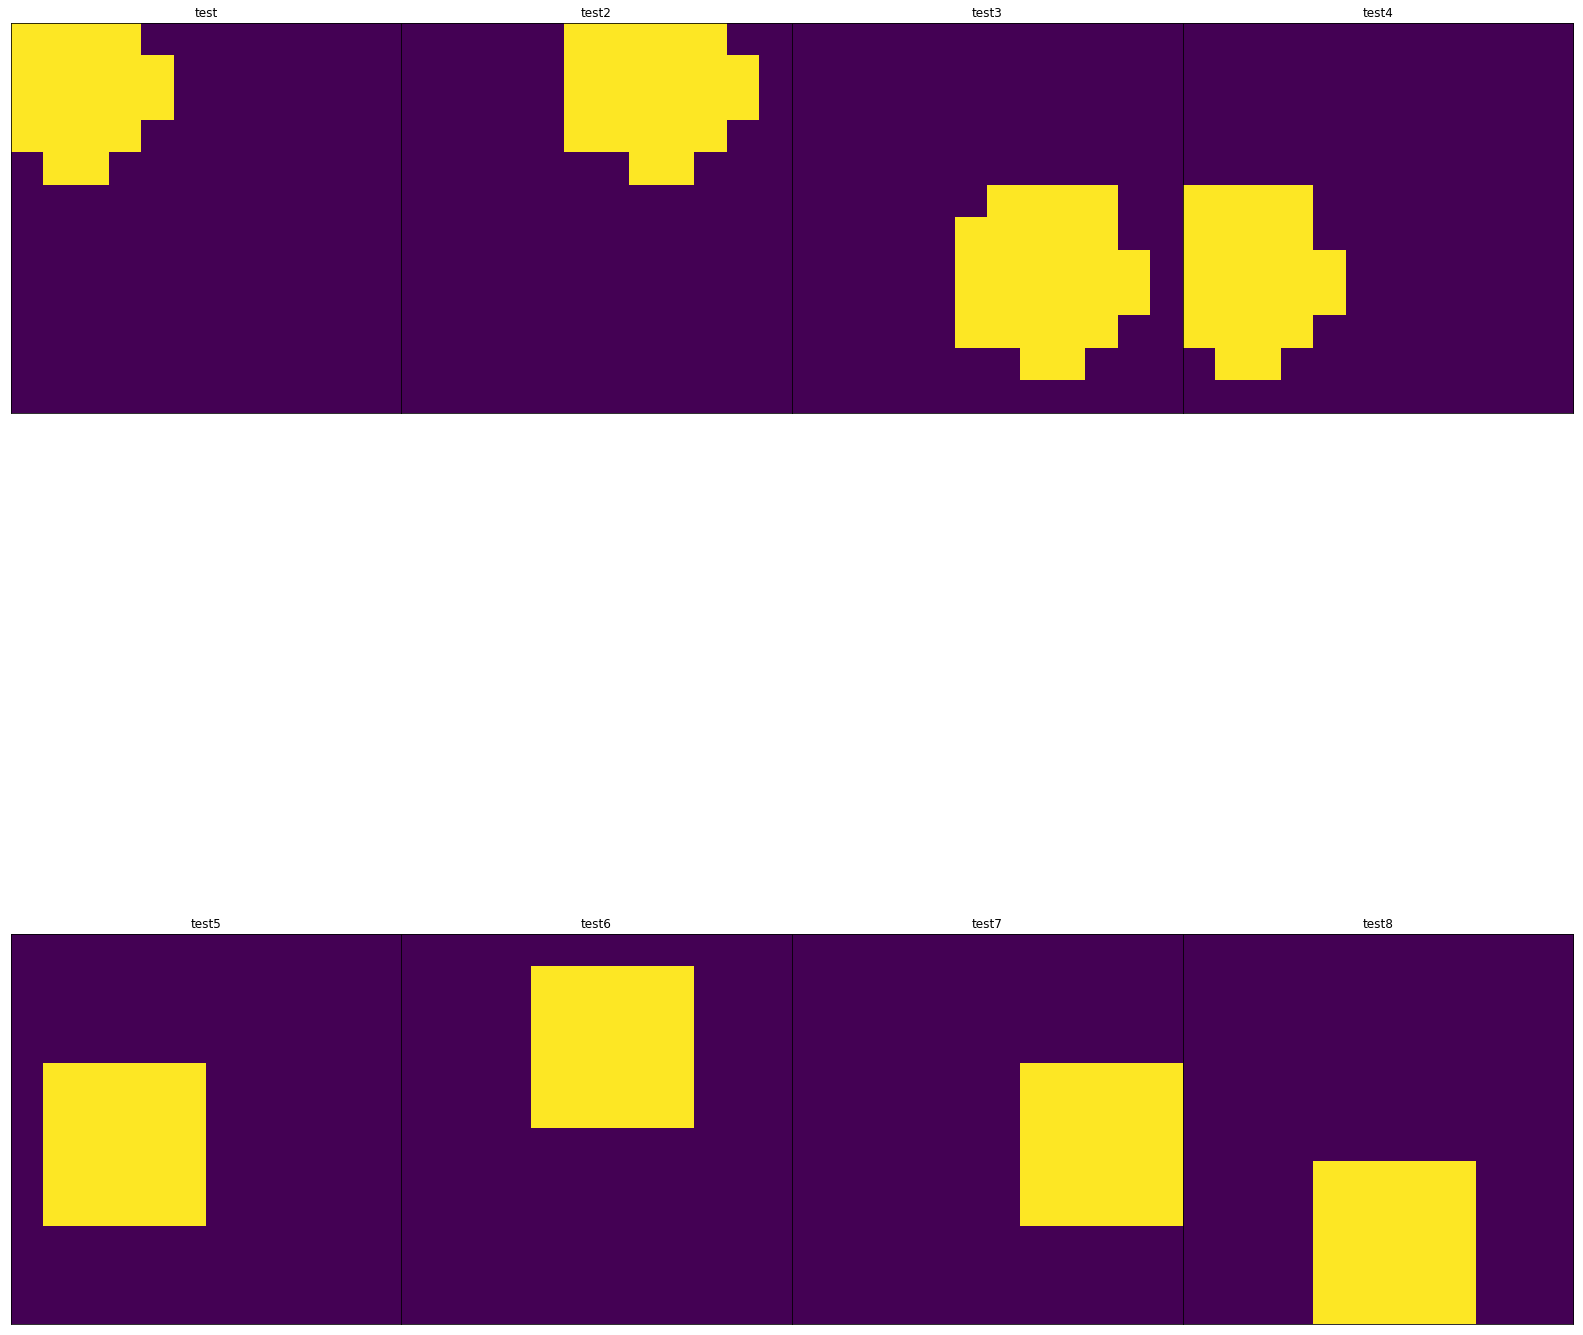

In [37]:

plt.figure(num=None, figsize=(28,32), facecolor='w', edgecolor='k')
ax = [plt.subplot(2,4,i+1) for i in range(8)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0,hspace=0.1)


ax[0].title.set_text("test")
ax[0].imshow(createOpposingMask(3, 3, 0))
ax[1].title.set_text("test2")
ax[1].imshow(createOpposingMask(3, 3, 1))
ax[2].title.set_text("test3")
ax[2].imshow(createOpposingMask(3, 3, 2))
ax[3].title.set_text("test4")
ax[3].imshow(createOpposingMask(3, 3, 3))
ax[4].title.set_text("test5")
ax[4].imshow(createOpposingMask(3, 3, 4))
ax[5].title.set_text("test6")
ax[5].imshow(createOpposingMask(3, 3, 5))
ax[6].title.set_text("test7")
ax[6].imshow(createOpposingMask(3, 3, 6))
ax[7].title.set_text("test8")
ax[7].imshow(createOpposingMask(3, 3, 7))

In [15]:
skyViewArr = np.asarray(Image.open("../cropped_data/croppedImage_Skyview200x200.tif"))
skyViewArr.shape

(200, 200)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
8688


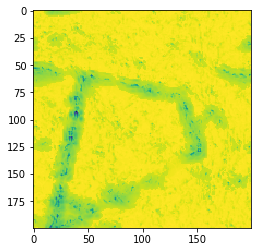

In [96]:
newSkyViewArr = OpposingCircleFilter(skyViewArr, 3, 3, 0.9875)
plt.imshow(newSkyViewArr)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
4871
0.9964563
0.9960848
0.99561256
0.99515975
0.9950358
0.9945345
0.96458197
0.9607866
0.9572765
0.95513546
0.95319617
0.9514632
0.94984245
0.9485059
0.9474411
0.94626117
0.94474953
0.94302493
0.9410133
0.9389399
0.93716246
0.9357694
0.93475634
0.934174
0.93404603
0.9344782
0.935473
0.9367871
0.93830884
0.93

0.9939004
0.9938661
0.9936415
0.99285114
0.99230844
0.9917018
0.99062693
0.98986316
0.98976207
0.98908544
0.9880579
0.9880287
0.9886106
0.98988545
0.9907947
0.9913999
0.9918806
0.9919814
0.9922559
0.9924515
0.99242246
0.99204093
0.99135125
0.99060017
0.9907162
0.9912977
0.9917904
0.9924986
0.99285954
0.9931668
0.9934203
0.993986
0.9951523
0.9958897
0.99575984
0.9954901
0.9947927
0.9942202
0.9944762
0.99495775
0.9951534
0.9952361
0.99523157
0.99536544
0.9957053
0.99578804
0.9959629
0.99591726
0.99581856
0.9959657
0.9959713
0.9958184
0.9957413
0.9955668
0.9953365
0.9952379
0.9952427
0.9952441
0.9953171
0.99537766
0.99545324
0.9955707
0.9957757
0.99594516
0.99584144
0.99570686
0.9954811
0.99506426
0.9942927
0.9934572
0.99248284
0.991625
0.9909616
0.99057937
0.99055314
0.9910192
0.9909243
0.99057776
0.99087626
0.9910872
0.99144953
0.992049
0.9923842
0.9931025
0.9938448
0.9943272
0.9942098
0.99343127
0.99291486
0.9926517
0.99224937
0.9920565
0.9918267
0.99157447
0.9915043
0.9920077
0.992797

0.9946982
0.99423814
0.9940139
0.993738
0.9932395
0.99322647
0.9935286
0.99401563
0.99471676
0.99484515
0.99499136
0.9950109
0.9951004
0.99550885
0.9956705
0.9954047
0.99505675
0.9945033
0.99385154
0.9932937
0.9927199
0.9923972
0.9926737
0.99237967
0.9916758
0.9920642
0.99255466
0.99269754
0.9925639
0.9924702
0.99168354
0.99151564
0.99163604
0.99224436
0.9923122
0.9921524
0.99200094
0.9924309
0.9931567
0.99397737
0.9945314
0.9953006
0.9959407
0.99627477
0.996338
0.9964596
0.99661684
0.9967057
0.996721
0.9964146
0.9959544
0.9957377
0.99574184
0.9959312
0.99593455
0.99581194
0.9957177
0.99557984
0.9954044
0.9958839
0.9960147
0.995934
0.9957937
0.99559563
0.9954344
0.995715
0.9954138
0.9939535
0.992869
0.991608
0.99020743
0.98886365
0.9874404
0.9860366
0.9849923
0.985838
0.98626596
0.98675233
0.98663497
0.98689216
0.987467
0.987893
0.987792
0.98754793
0.9867193
0.98526716
0.98409396
0.98326594
0.9823761
0.98141444
0.98034877
0.97917265
0.9778238
0.9773727
0.9774235
0.977281
0.97752273
0.9

0.98592794
0.98625535
0.98649454
0.987098
0.9872638
0.9870999
0.98620033
0.9854692
0.98440844
0.9828514
0.9818273
0.9808342
0.98071307
0.9813931
0.9817242
0.9822566
0.98305047
0.9840975
0.985088
0.98544663
0.9861382
0.9864462
0.98738724
0.988004
0.9887821
0.9889835
0.9891863
0.989793
0.9904441
0.9912777
0.9919834
0.99194115
0.99256593
0.99277693
0.9924964
0.99223477
0.99158555
0.9911199
0.9902817
0.98952967
0.98866814
0.9877754
0.9861471
0.9841117
0.98228467
0.9812931
0.98036593
0.98024315
0.9797471
0.9803608
0.9813754
0.9830005
0.9845568
0.9858353
0.9876045
0.98985356
0.9915226
0.9931912
0.9936464
0.9939362
0.9943462
0.99479187
0.9949935
0.9949953
0.9947595
0.9946805
0.9945326
0.99407935
0.9940786
0.99424875
0.99435544
0.99482554
0.9953322
0.9954539
0.9958912
0.9962856
0.9965247
0.9967033
0.99688023
0.99692714
0.9967895
0.9965545
0.9964209
0.9960962
0.9959843
0.9956118
0.9951065
0.9950703
0.99506617
0.99520755
0.9954271
0.9950824
0.99500877
0.9949172
0.99466246
0.9940219
0.99319035
0.

0.99419767
0.9939808
0.9939383
0.99388075
0.99410635
0.9942326
0.9946261
0.99502486
0.9951365
0.99540406
0.99557644
0.99558794
0.9956926
0.9957536
0.9955663
0.99498343
0.994484
0.9943719
0.9936972
0.9921126
0.9902577
0.9883839
0.9865898
0.98520166
0.98328906
0.9808609
0.97877115
0.9774025
0.9763747
0.97679347
0.97637403
0.9776967
0.9791191
0.98139614
0.98339206
0.98519504
0.9870728
0.9889439
0.99016297
0.9916053
0.9909263
0.9898401
0.98962486
0.98921984
0.98955375
0.9894801
0.9887184
0.9883938
0.9885467
0.9887646
0.9897035
0.9899266
0.99008095
0.9901404
0.99083084
0.99180764
0.99277276
0.99336946
0.9942987
0.99460876
0.9948786
0.9948513
0.9949193
0.9950328
0.99461997
0.99409175
0.99373007
0.9934232
0.992691
0.9918962
0.99148524
0.990768
0.9902613
0.99025345
0.9893578
0.9895808
0.9607461
0.9595692
0.95532703
0.95595336
0.9567491
0.9575797
0.95844954
0.9594377
0.95975685
0.9603538
0.96105725
0.96183705
0.9627337
0.96351254
0.96388894
0.9643854
0.9648603
0.98063517
0.9820761
0.98356724
0.

0.96054953
0.96146655
0.9622599
0.9628749
0.96313494
0.96313715
0.9630109
0.96275896
0.9624676
0.9622425
0.9617984
0.9609129
0.9597972
0.9587177
0.9578214
0.9571127
0.9557734
0.9530833
0.95101446
0.9496675
0.94741994
0.94418496
0.9433673
0.94258106
0.94273347
0.9408357
0.9391542
0.94159245
0.9452355
0.94723254
0.94930845
0.9504528
0.9510317
0.95228386
0.9530666
0.9540605
0.9551053
0.9560562
0.9571223
0.9585131
0.9604553
0.96273285
0.96505225
0.97229755
0.97292036
0.97395784
0.97525793
0.9768942
0.9792346
0.98143405
0.9828932
0.98457146
0.9852997
0.98597664
0.9861365
0.98611873
0.98569703
0.9850273
0.98448706
0.9844211
0.9844936
0.9854499
0.9860201
0.98695076
0.9875003
0.987993
0.98817843
0.98810524
0.9873116
0.9867084
0.9651362
0.964649
0.96448416
0.9646472
0.9650863
0.98841906
0.9889494
0.9902125
0.9918418
0.99279237
0.9936906
0.99360746
0.99353856
0.9935127
0.9934972
0.9933758
0.99354804
0.9937908
0.9937034
0.99437565
0.9945152
0.9947442
0.99471205
0.9947524
0.9952153
0.9951705
0.995

0.96463424
0.977063
0.97755724
0.9780093
0.9777198
0.9772827
0.9768726
0.97659355
0.97616905
0.9762167
0.97521573
0.9741842
0.97451377
0.9738213
0.9738318
0.97446716
0.97506976
0.97613275
0.9772653
0.9795122
0.9819828
0.9835887
0.9857486
0.9874826
0.9888602
0.990783
0.99220854
0.99227273
0.992546
0.9928915
0.993102
0.9920393
0.9909898
0.990477
0.9901166
0.9893896
0.9878632
0.9862574
0.9850035
0.9848797
0.98557204
0.98662186
0.9871252
0.9878926
0.9886358
0.99101317
0.9933069
0.9949635
0.9952467
0.9953564
0.99502367
0.99483705
0.9947601
0.9946359
0.99443
0.9939727
0.99334425
0.9931173
0.99329996
0.9929987
0.99218386
0.9907611
0.9894796
0.988203
0.9870761
0.9859709
0.98497653
0.9841297
0.9838814
0.984173
0.98438966
0.9849084
0.98597586
0.9873995
0.98834276
0.9888411
0.9899225
0.98722786
0.9873108
0.98731947
0.9876944
0.9883045
0.9890171
0.9898176
0.9905427
0.9911068
0.9913687
0.99208814
0.99251395
0.9929488
0.9935535
0.9936594
0.99393296
0.99425
0.99435616
0.9946551
0.9948116
0.9949221
0.

0.9918439
0.9925044
0.99242544
0.99174565
0.99051636
0.98880184
0.9864863
0.9629765
0.9603708
0.9580885
0.95630294
0.9547791
0.95345813
0.94833994
0.9405924
0.93402684
0.92935556
0.92651534
0.92509764
0.92513096
0.92679924
0.93088174
0.9369626
0.9440047
0.9470567
0.94926256
0.9520937
0.9554959
0.95927626
0.96321845
0.988595
0.98948616
0.9884111
0.9884072
0.98850685
0.98905206
0.9897278
0.9903329
0.9908111
0.9920332
0.9927531
0.9936959
0.9942635
0.9940432
0.99366575
0.99320036
0.99312097
0.99290395
0.99279964
0.9926611
0.99277073
0.9925183
0.9926516
0.99323523
0.99403745
0.9948709
0.9959021
0.9963337
0.99652773
0.99630266
0.9959019
0.99528676
0.99444705
0.9939721
0.993483
0.99330926
0.99327576
0.99334866
0.9934834
0.99359614
0.9938834
0.99461025
0.99494356
0.99479145
0.9946486
0.9944364
0.9943361
0.9940898
0.9938523
0.9932949
0.9927982
0.9924291
0.9925341
0.9924154
0.9919657
0.99145573
0.99085325
0.990527
0.9904293
0.99042326
0.9904945
0.99020255
0.9901012
0.9900889
0.99026453
0.9903101

0.9969785
0.9968051
0.9963188
0.99595624
0.99550956
0.9948028
0.9944512
0.99331146
0.99079907
0.9876832
0.9840913
0.96440405
0.96194947
0.9599924
0.9585682
0.95542806
0.95141715
0.9484121
0.94631153
0.9449865
0.9443607
0.9446677
0.9454575
0.9457978
0.9469165
0.9486287
0.95086056
0.9535323
0.9565374
0.95924866
0.9600555
0.96093637
0.9612331
0.96058
0.95998156
0.9594266
0.9590514
0.9589005
0.9589688
0.95935
0.9600356
0.960963
0.96080273
0.9605788
0.9591646
0.95827323
0.9580215
0.958443
0.9595129
0.9610666
0.96306664
0.97234166
0.975445
0.9787231
0.98205525
0.98452497
0.98721784
0.9899185
0.992234
0.9936776
0.9947931
0.99483496
0.9951433
0.9953873
0.9955138
0.99566925
0.99580234
0.99591655
0.99599206
0.99564683
0.9956248
0.995911
0.99624425
0.99656695
0.9967377
0.99686694
0.9969325
0.9968185
0.99410456
0.9945382
0.99485934
0.99448216
0.9941299
0.9938558
0.9938697
0.9938897
0.9937084
0.9934569
0.9928087
0.9921047
0.9916717
0.99129856
0.9902902
0.9892809
0.98865587
0.98815304
0.98761934
0.9

0.9906062
0.9914156
0.9910138
0.9627354
0.95962256
0.9570595
0.95452696
0.950359
0.9468138
0.94399047
0.94210696
0.9377048
0.93369395
0.9301295
0.9279165
0.9270537
0.9274467
0.9292975
0.9317012
0.932876
0.93520397
0.93849766
0.94265175
0.9475979
0.9530837
0.9585306
0.9636045
0.9890038
0.9919531
0.994079
0.99509966
0.99521804
0.9950453
0.994744
0.99434024
0.9940437
0.9935108
0.99305564
0.99295586
0.9927785
0.9926944
0.9927759
0.9926396
0.9924439
0.9925794
0.99230653
0.99156445
0.9913679
0.9913428
0.98994243
0.98887014
0.98785263
0.98718524
0.9874342
0.9879629
0.9873589
0.98653984
0.9862747
0.98677087
0.9877058
0.9884386
0.9886134
0.9887367
0.9882657
0.9871327
0.9858184
0.9854122
0.98494107
0.9837466
0.98357534
0.9841096
0.9847325
0.9866078
0.9889231
0.9908223
0.9921337
0.9933853
0.9949179
0.99621034
0.99686015
0.9969594
0.99682915
0.99604976
0.99514693
0.9938819
0.992969
0.99183863
0.99115163
0.99043447
0.99016047
0.9897515
0.990443
0.9909644
0.9917425
0.99260557
0.9931964
0.99352443
0.

0.98643106
0.9874652
0.98831564
0.9888856
0.99011433
0.991459
0.99250424
0.99348915
0.99431
0.994729
0.99460185
0.9940495
0.9935965
0.9931501
0.99153215
0.9894882
0.98666275
0.9842212
0.9822751
0.9646759
0.96099585
0.95718807
0.95338196
0.9498845
0.946692
0.943649
0.9406679
0.93802947
0.9362153
0.93574816
0.93632704
0.93774873
0.9396374
0.94225633
0.946005
0.9509999
0.9541626
0.9560351
0.9582283
0.96072423
0.96361125
0.9880292
0.98986876
0.99114877
0.9915046
0.9917948
0.9920524
0.99207294
0.9920548
0.9920025
0.9919075
0.99199015
0.991105
0.9903341
0.98965085
0.9888189
0.98790544
0.98654866
0.9847738
0.9832762
0.98234904
0.98246384
0.98196286
0.98070943
0.9789998
0.97870386
0.9790832
0.98149025
0.9827151
0.9832093
0.98407227
0.98442686
0.9842119
0.9838554
0.98290205
0.981498
0.9794517
0.97888184
0.9786458
0.9768934
0.9764583
0.975611
0.9742802
0.97344387
0.9727503
0.97110975
0.96959174
0.9694344
0.96897155
0.96899706
0.96940756
0.9707189
0.9730136
0.97632235
0.9788776
0.9813411
0.984016

0.9904383
0.9906738
0.9910818
0.99149084
0.9915303
0.9912932
0.9910947
0.9909862
0.99038374
0.9894379
0.9882738
0.9869841
0.9853438
0.983567
0.98193836
0.97998834
0.9778166
0.9753503
0.96444887
0.96227753
0.9600757
0.9578873
0.95582443
0.95392
0.95233727
0.95117295
0.95055884
0.95053285
0.95104575
0.9520492
0.95217633
0.95232105
0.95305485
0.9534166
0.95344174
0.95395106
0.95493907
0.956327
0.958017
0.9600692
0.9624386
0.9651646
0.991522
0.9923165
0.99271584
0.9929643
0.9932198
0.9931972
0.99345946
0.99370795
0.9930002
0.9915023
0.9903618
0.98871696
0.98859054
0.98886937
0.98815215
0.98781216
0.9884374
0.9890691
0.9906583
0.9919309
0.9930135
0.9925688
0.99246407
0.99267983
0.99277854
0.99274397
0.99283427
0.99316984
0.9936354
0.9941186
0.99444515
0.9948953
0.99517024
0.9952942
0.99513096
0.9950876
0.9950779
0.99479306
0.9952928
0.9952113
0.9949762
0.99489075
0.99500793
0.9951767
0.9949928
0.99460673
0.994493
0.99439853
0.9942741
0.9943404
0.99397266
0.9936421
0.9931801
0.99181265
0.989

0.9571186
0.95503145
0.95319355
0.9519295
0.94786674
0.9449462
0.94120777
0.93905085
0.93817794
0.93844527
0.9389854
0.9418077
0.94644856
0.95131075
0.95532995
0.95691276
0.9586828
0.9600613
0.9619361
0.9644925
0.99047774
0.99315566
0.9939382
0.99378264
0.9936245
0.99402237
0.9943859
0.99438375
0.9943366
0.9940253
0.9935521
0.9928088
0.9923773
0.99221385
0.9919854
0.991936
0.9919154
0.9920899
0.99272627
0.9936807
0.99458426
0.99486303
0.9942459
0.99402505
0.9941276
0.994281
0.99366
0.99256307
0.9910241
0.98961985
0.989084
0.98865414
0.9885622
0.9885418
0.9883853
0.98886615
0.98962706
0.9902801
0.9912272
0.99159956
0.9920359
0.9924417
0.99223727
0.99186563
0.9914273
0.99155945
0.991733
0.9920757
0.99235475
0.9923606
0.99212545
0.9924899
0.9928684
0.99343634
0.9935236
0.9935669
0.99331725
0.9933002
0.993139
0.99251556
0.9911029
0.98941416
0.98788387
0.9871361
0.98605865
0.98480004
0.9834741
0.9823835
0.98195606
0.9815321
0.9807809
0.9805425
0.9809436
0.98113805
0.9811233
0.9812294
0.9809

0.9845452
0.9864673
0.98745245
0.9894306
0.99116474
0.99255764
0.9929747
0.99300265
0.99319184
0.9933544
0.9935336
0.99338573
0.99304646
0.9928748
0.9925931
0.9928914
0.99342686
0.9931628
0.99270433
0.9924688
0.9925641
0.9928666
0.99313253
0.9936724
0.99394333
0.9941928
0.9944635
0.99415743
0.9938106
0.99305254
0.99249935
0.9922669
0.99113536
0.98987406
0.9894878
0.9888763
0.98762625
0.9858803
0.98506635
0.9835332
0.98312294
0.98401463
0.98344177
0.98245484
0.9830699
0.9840457
0.98616314
0.987966
0.9896922
0.99030644
0.9906123
0.9909123
0.9914446
0.9907028
0.98959434
0.9874764
0.9844674
0.98193204
0.9801531
0.9791303
0.9786147
0.978437
0.97783726
0.9778683
0.9789588
0.98033696
0.98041904
0.9810051
0.98124135
0.98062116
0.9799253
0.9807967
0.9814232
0.98331267
0.98458654
0.98611134
0.987614
0.98844504
0.9902498
0.9918632
0.9932994
0.9925033
0.99259806
0.99263066
0.99302655
0.9941769
0.99518925
0.9956578
0.9958051
0.9959465
0.99625975
0.9964082
0.9965319
0.996559
0.9952524
0.99259424
0.9

0.9258739
0.92007446
0.9159659
0.9129038
0.91217154
0.91098547
0.91414315
0.919876
0.9254497
0.9283052
0.9279514
0.928429
0.92976594
0.93197757
0.93359345
0.9358947
0.9385648
0.9414984
0.9445708
0.94754153
0.95034546
0.95283926
0.9548858
0.9557341
0.9565504
0.95737064
0.958324
0.95947874
0.9607587
0.96207285
0.9626232
0.9621813
0.96164906
0.96133316
0.96140265
0.96172565
0.9621706
0.96268994
0.96122104
0.9598433
0.9586419
0.9576247
0.9568079
0.95616823
0.9556807
0.9552883
0.95489234
0.9543894
0.9537497
0.952981
0.9514006
0.9498941
0.94871515
0.94797975
0.9475262
0.94722754
0.94675624
0.9460501
0.9450481
0.9447466
0.9452706
0.94668746
0.9471941
0.94788855
0.94883025
0.9501418
0.95178723
0.9533832
0.9543457
0.95554733
0.957068
0.958891
0.96089244
0.9630806
0.9780418
0.98111403
0.9833192
0.9856694
0.9880166
0.9900938
0.99116147
0.99119836
0.9904999
0.9902235
0.9899917
0.98986554
0.98991114
0.99000984
0.9901399
0.9906478
0.9919888
0.99340963
0.99449444
0.9951582
0.995544
0.9956765
0.995942

0.93012124
0.92682874
0.9244932
0.9231411
0.92259496
0.92287105
0.92396337
0.92603946
0.92877746
0.93201566
0.9341779
0.9349735
0.9362569
0.93790704
0.93976486
0.940757
0.940964
0.9409713
0.9409553
0.9410501
0.94134945
0.94173723
0.94203484
0.9423095
0.9425262
0.94259
0.9423822
0.9419608
0.9414167
0.94082195
0.94040877
0.9404582
0.9410456
0.9420707
0.94356394
0.9456594
0.94830287
0.951413
0.95451033
0.9540344
0.9538772
0.9541382
0.95478004
0.9557671
0.957195
0.95900834
0.96117634
0.9634922
0.9887122
0.98984295
0.9906513
0.9904131
0.98993707
0.99017113
0.99020743
0.990206
0.98988533
0.9893689
0.9892176
0.98956186
0.99017113
0.9911092
0.99178714
0.99277925
0.99309635
0.9934405
0.99480164
0.99534273
0.9956143
0.99591917
0.99590635
0.99595547
0.9961117
0.99613637
0.996262
0.9963178
0.9964516
0.99650455
0.99640185
0.99609923
0.9955013
0.99514323
0.99533236
0.99542576
0.99524224
0.9953092
0.9949405
0.9944969
0.9943463
0.994476
0.99454015
0.99405223
0.9934133
0.992825
0.99119985
0.9905966
0.9

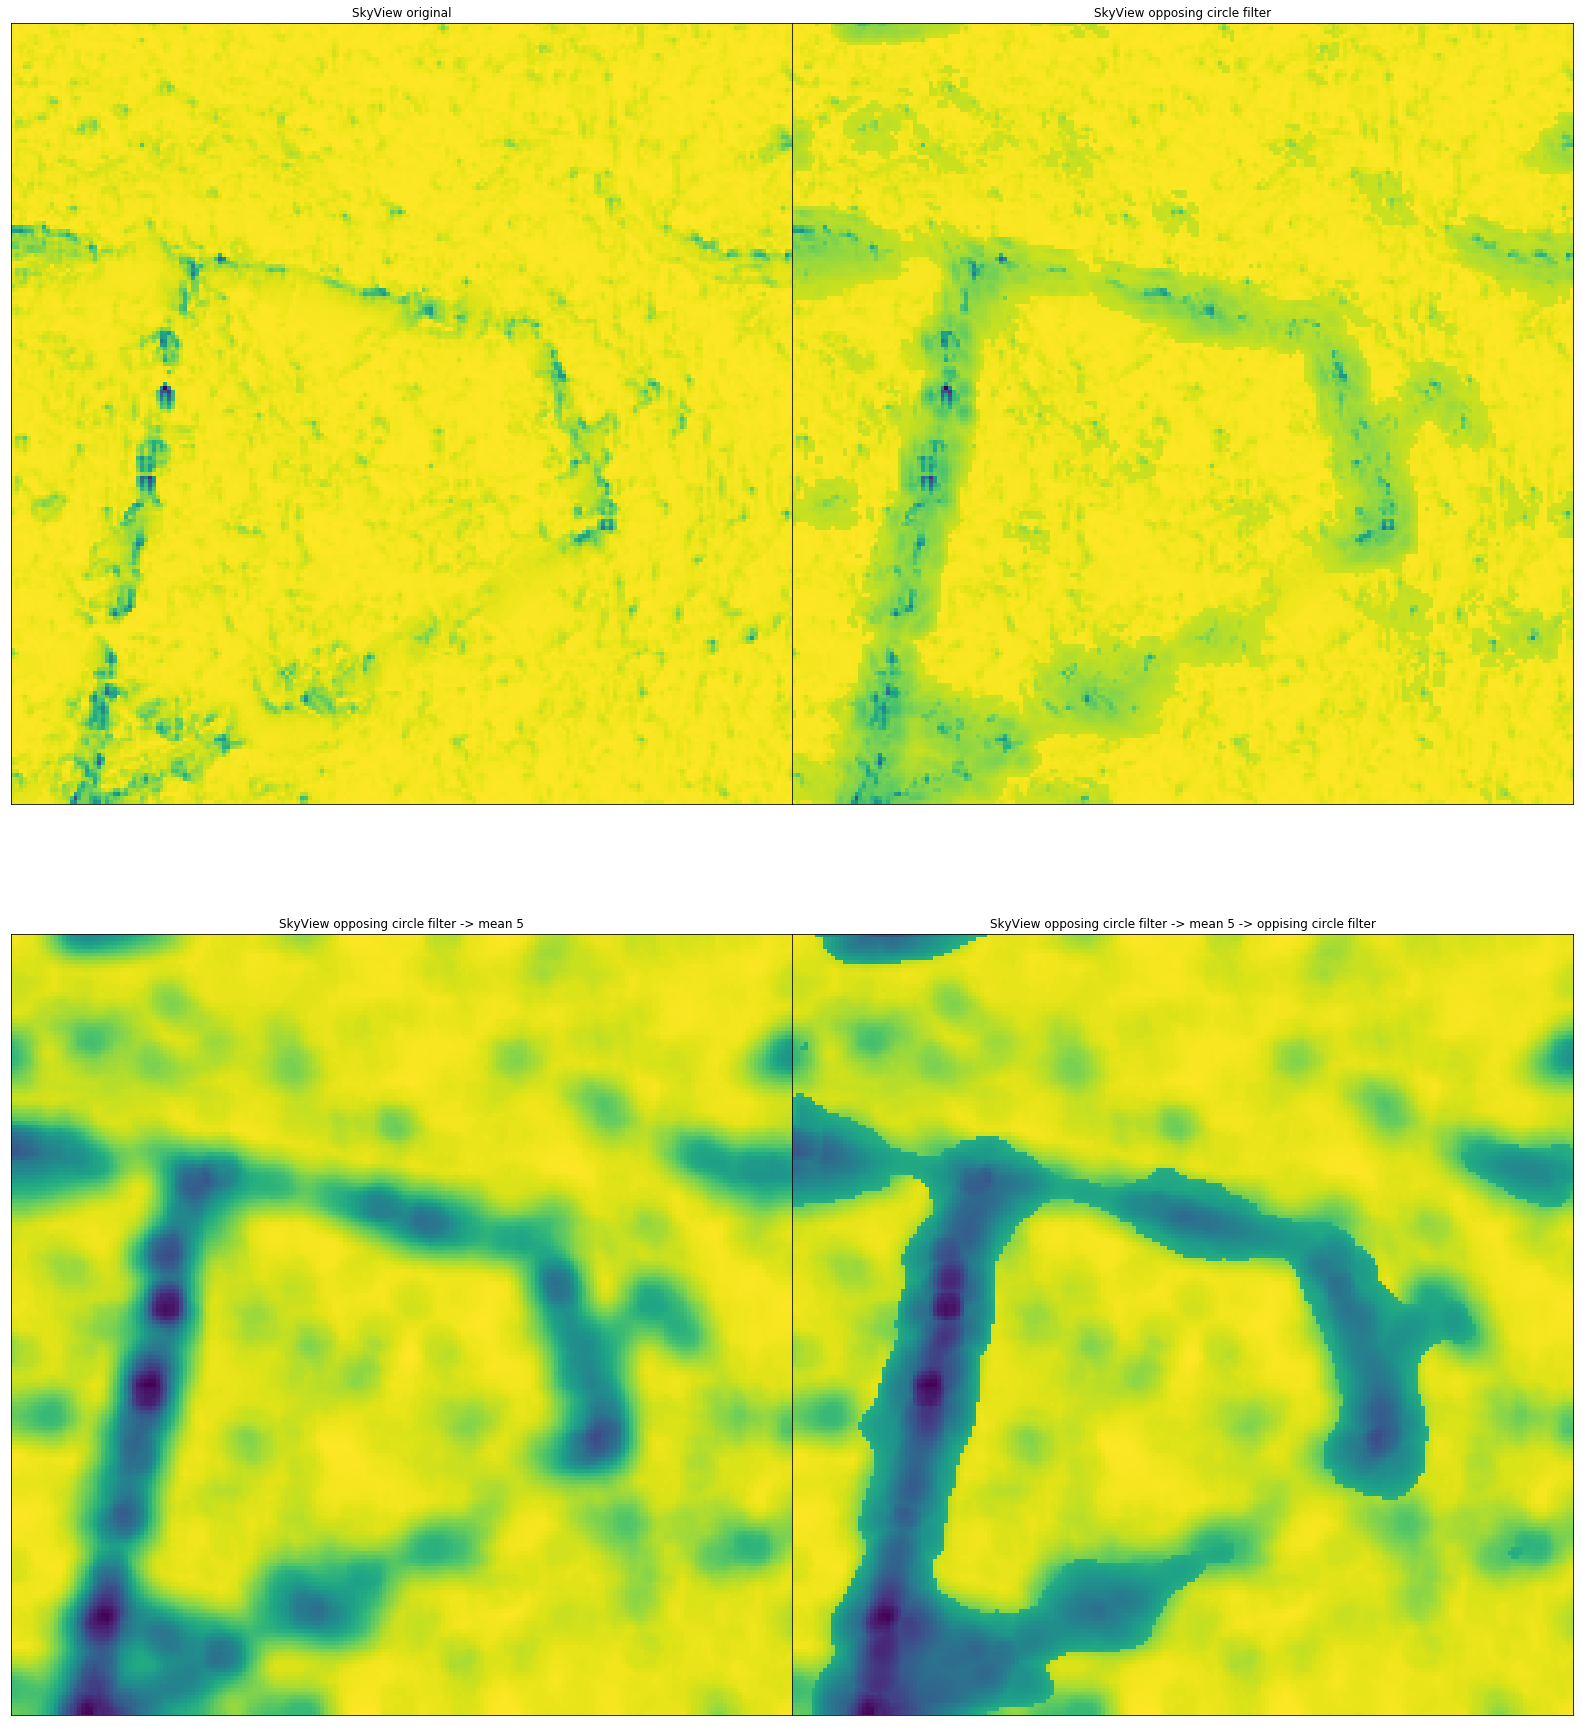

In [99]:
plt.figure(num=None, figsize=(28,32), facecolor='w', edgecolor='k')
ax = [plt.subplot(2,2,i+1) for i in range(4)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0,hspace=0.1)

mean = gf(newSkyViewArr, np.nanmean, footprint=create_circular_mask(5))

newNewSkyViewArr = OpposingCircleFilter(mean, 3, 6, 0.975)

for row in newNewSkyViewArr:
    for pixel in row:
        print(pixel)

ax[0].title.set_text("SkyView original")
ax[0].imshow(skyViewArr)
ax[1].title.set_text("SkyView opposing circle filter")
ax[1].imshow(newSkyViewArr)
ax[2].title.set_text("SkyView opposing circle filter -> mean 5")
ax[2].imshow(mean)
ax[3].title.set_text("SkyView opposing circle filter -> mean 5 -> oppising circle filter")
ax[3].imshow(newNewSkyViewArr)

In [189]:
import os

for folder in os.listdir("../cropped_data/3_zones"):
    for imageName in os.listdir(f"../cropped_data/3_zones/{folder}"):
        print(imageName)
        np.save(f"{imageName[23:-4]}_raw.npy", np.asarray(Image.open(f"../cropped_data/3_zones/{folder}/{imageName}")))


croppedImage_2625x3000_Ditches_zone1.tif
croppedImage_2625x3000_HPMF_zone1.tif
croppedImage_2625x3000_Impoundment_zone1.tif
croppedImage_2625x3000_Skyview_zone1.tif
croppedImage_2625x3000_Slope_zone1.tif
croppedImage_2625x3000_Ditches_zone2.tif
croppedImage_2625x3000_HPMF_zone2.tif
croppedImage_2625x3000_Impoundment_zone2.tif
croppedImage_2625x3000_Skyview_zone2.tif
croppedImage_2625x3000_Slope_zone2.tif
croppedImage_2625x3000_Ditches_zone3.tif
croppedImage_2625x3000_HPMF_zone3.tif
croppedImage_2625x3000_Impoundment_zone3.tif
croppedImage_2625x3000_Skyview_zone3.tif
croppedImage_2625x3000_Slope_zone3.tif


In [ ]:
#im = Image.open("../cropped_data/croppedImage_skyview130x130.tif")
#im = Image.open("../cropped_data/croppedImage_skyview200x200.tif")
#im = Image.open("../cropped_data/croppedImage_impoundment400x400.tif")
#im = Image.open("../cropped_data/croppedImage_skyview400x400.tif")
#im = Image.open("../cropped_data/croppedImage_skyview2500x2500.tif")
#im = Image.open("../cropped_data/croppedImage_skyview1000x1000.tif")
#skyViewIm = Image.open("../cropped_data/croppedImage_Skyview500x500_10299_10601_10799_11101.tif")
#skyViewArr = np.asarray(skyViewIm)
#slopeIm = Image.open("../cropped_data/croppedImage_Slope500x500.tif")
#slopeArr = np.asarray(slopeIm)
#impoundmentIm = Image.open("../cropped_data/croppedImage_Impoundment500x500.tif")
#impoundmentArr = np.asarray(impoundmentIm)
#HPMFIm = Image.open("../cropped_data/croppedImage_HPMF500x500.tif")
#HPMFArr = np.asarray(HPMFIm)
#ditchesIm = Image.open("../cropped_data/croppedImage_Ditches500x500.tif")
#ditchesArr = np.asarray(ditchesIm)

#skyViewIm = Image.open("../cropped_data/croppedImage_2625x3000_skyview_9950_8302_12575_11302.tif")
#skyViewArr = np.asarray(skyViewIm)
#slopeIm = Image.open("../cropped_data/croppedImage_2625x3000_Slope.tif")
#slopeArr = np.asarray(slopeIm)
#impoundmentIm = Image.open("../cropped_data/croppedImage_2625x3000_Impoundment.tif")
#impoundmentArr = np.asarray(impoundmentIm)
#HPMFIm = Image.open("../cropped_data/croppedImage_2625x3000_HPMF.tif")
#HPMFArr = np.asarray(HPMFIm)
#ditchesIm = Image.open("../cropped_data/croppedImage_2625x3000_Ditches.tif")
#ditchesArr = np.asarray(ditchesIm)

In [160]:
newConicArr = conicMean(skyViewArr, 5, 0.975)

circ_mask3 = create_circular_mask(3)
circ_mask4 = create_circular_mask(4)
circ_mask6 = create_circular_mask(6)
circ_mask15 = create_circular_mask(15)
circ_mask25 = create_circular_mask(25)

meanGreyOpen = morph.grey_opening(gf(newConicArr,np.nanmean,footprint=circ_mask4), footprint=circ_mask4)



np.save("hpmf_feature_means3_zone3.npy", gf(HPMFArr,np.nanmean,footprint=circ_mask3))
np.save("slope_feature_mean3_zone3.npy", gf(slopeArr,np.nanmean,footprint=circ_mask3))
np.save("impoundment_feature_mean3_zone3.npy", gf(impoundmentArr,np.nanmean,footprint=circ_mask3))
np.save("skyview_feature_cone_5_0975_mean4_opening4.npy", meanGreyOpen)
np.save("ditches_zone3.npy", ditchesArr)



575007


'\nhpmf = np.load("hpmf_feature500.npy")\nslope = np.load("slope_feature500.npy")\nimpoundment = np.load("impoundment_feature500.npy")\nskyview = np.load("skyview_feature500.npy")\n\nplt.figure(num=None, figsize=(28,26), facecolor=\'w\', edgecolor=\'k\')\nax = [plt.subplot(3,4,i+1) for i in range(12)]\nfor a in ax:\n    a.set_xticklabels([])\n    a.set_yticklabels([])\n    a.tick_params(bottom=False, left=False)\nplt.subplots_adjust(wspace=0,hspace=0)\n\n\nax[0].title.set_text("Original Slope")\nax[0].imshow(slopeArr)\n\nax[1].title.set_text("Slope mean 6")\nax[1].imshow(slope)\n\nax[2].title.set_text("Original SkyViewFactor")\nax[2].imshow(skyViewArr)\n\nax[3].title.set_text("SkyViewFactor Conic Filter: 5, 0.975,\n mean 4 grey open 4")\nax[3].imshow(skyview)\n\nax[4].title.set_text("Original Impoundment")\nax[4].imshow(impoundmentArr)\n\nax[5].title.set_text("Impoundment mean 3")\nax[5].imshow(impoundment)\n\nax[6].title.set_text("HPMF Original")\nax[6].imshow(HPMFArr)\n\nax[7].title.